In [1]:
!wget -O moviedataset.zip http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip -o moviedataset.zip -d /resources/data

--2017-04-27 00:42:43--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.146
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.146|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘moviedataset.zip’

100%[======================================>] 5,917,549   15.1MB/s   in 0.4s   

2017-04-27 00:42:44 (15.1 MB/s) - ‘moviedataset.zip’ saved [5917549/5917549]

Archive:  moviedataset.zip
  inflating: /resources/data/ml-1m/movies.dat  
  inflating: /resources/data/ml-1m/ratings.dat  
  inflating: /resources/data/ml-1m/README  
  inflating: /resources/data/ml-1m/users.dat  


In [2]:
#Tensorflow library. Used to implement machine learning models
import tensorflow as tf
#Numpy contains helpful functions for efficient mathematical calculations
import numpy as np
#Dataframe manipulation library
import pandas as pd
#Graph plotting library
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Loading in the movies dataset
movies_df = pd.read_csv('/resources/data/ml-1m/movies.dat', sep='::', header=None)
movies_df.head()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  from ipykernel import kernelapp as app


,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
We can do the same for the ratings.dat file:


In [4]:


#Loading in the ratings dataset
ratings_df = pd.read_csv('/resources/data/ml-1m/ratings.dat', sep='::', header=None)
ratings_df.head()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [6]:
movies_df.columns = ['MovieID', 'Title', 'Genres']

ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [7]:
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
len(movies_df)

3883

In [9]:
movies_df.tail()

,MovieID,Title,Genres
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama
3882,3952,"Contender, The (2000)",Drama|Thriller


In [10]:
movies_df['List Index'] = movies_df.index
movies_df.head()

,MovieID,Title,Genres,List Index
0,1,Toy Story (1995),Animation|Children's|Comedy,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,Waiting to Exhale (1995),Comedy|Drama,3
4,5,Father of the Bride Part II (1995),Comedy,4


In [11]:
#Merging movies_df with ratings_df by MovieID
merged_df = movies_df.merge(ratings_df, on='MovieID')
#Dropping unecessary columns
merged_df = merged_df.drop('Timestamp', axis=1).drop('Title', axis=1).drop('Genres', axis=1)
#Displaying the result
merged_df.head()

,MovieID,List Index,UserID,Rating
0,1,0,1,5
1,1,0,6,4
2,1,0,8,4
3,1,0,9,5
4,1,0,10,5


In [12]:
#Group up by UserID
userGroup = merged_df.groupby('UserID')
userGroup.first().head()

,MovieID,List Index,Rating
UserID,,,
1,1,0,5
2,21,20,1
3,104,102,4
4,260,257,5
5,6,5,2


In [13]:
#Amount of users used for training
amountOfUsedUsers = 1000
#Creating the training list
trX = []
#For each user in the group
for userID, curUser in userGroup:
    #Create a temp that stores every movie's rating
    temp = [0]*len(movies_df)
    #For each movie in curUser's movie list
    for num, movie in curUser.iterrows():
        #Divide the rating by 5 and store it
        temp[movie['List Index']] = movie['Rating']/5.0
    #Now add the list of ratings into the training list
    trX.append(temp)
    #Check to see if we finished adding in the amount of users for training
    if amountOfUsedUsers == 0:
        break
    amountOfUsedUsers -= 1

In [14]:
hiddenUnits = 20
visibleUnits = len(movies_df)
vb = tf.placeholder("float", [visibleUnits]) #Number of unique movies
hb = tf.placeholder("float", [hiddenUnits]) #Number of features we're going to learn
W = tf.placeholder("float", [visibleUnits, hiddenUnits])

In [15]:
#Phase 1: Input Processing
v0 = tf.placeholder("float", [None, visibleUnits])
_h0= tf.nn.sigmoid(tf.matmul(v0, W) + hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))
#Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

In [16]:
#Learning rate
alpha = 1.0
#Create the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
#Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])
#Create methods to update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

In [17]:
err = v0 - v1
err_sum = tf.reduce_mean(err * err)

In [18]:
#Current weight
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
#Current visible unit biases
cur_vb = np.zeros([visibleUnits], np.float32)
#Current hidden unit biases
cur_hb = np.zeros([hiddenUnits], np.float32)
#Previous weight
prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
#Previous visible unit biases
prv_vb = np.zeros([visibleUnits], np.float32)
#Previous hidden unit biases
prv_hb = np.zeros([hiddenUnits], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

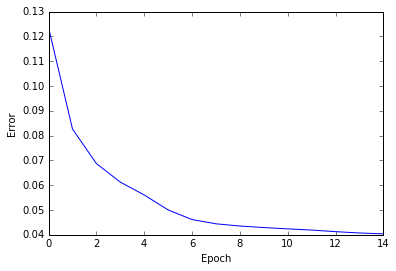

In [19]:
epochs = 15
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_nb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_nb}))
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

In [29]:
#Selecting the input user
inputUser = [trX[86]]

In [30]:
#Feeding in the user and reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})

In [31]:
movies_df["Recommendation Score"] = rec[0]
movies_df.sort_values("Recommendation Score", ascending=False).head(20)

,MovieID,Title,Genres,List Index,Recommendation Score
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,2502,0.851324
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,257,0.784885
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,476,0.776961
585,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,585,0.769296
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,1178,0.746210
1959,2028,Saving Private Ryan (1998),Action|Drama|War,1959,0.719668
108,110,Braveheart (1995),Action|Drama|War,108,0.670263
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,1192,0.555198
1220,1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller,1220,0.527838
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller,589,0.526832


In [32]:
#The End. Play around with the parameters, increase the number of hidden layers. Try using a different activation function.